In [165]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from xgboost import XGBRegressor
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_predict
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import MinMaxScaler,LabelEncoder
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_absolute_error,mean_squared_error,r2_score

In [139]:
train=pd.read_csv('train_data.csv',index_col=0)
test=pd.read_csv('test_data.csv',index_col=0)
train.head()

,airline,flight,source_city,departure_time,stops,arrival_time,destination_city,class,duration,days_left,price
id,,,,,,,,,,,
1,Vistara,UK-810,Bangalore,Early_Morning,one,Night,Mumbai,Economy,14.25,21,7212
2,SpiceJet,SG-5094,Hyderabad,Evening,zero,Night,Kolkata,Economy,1.75,7,5292
3,Vistara,UK-846,Bangalore,Morning,one,Evening,Delhi,Business,9.58,5,60553
4,Vistara,UK-706,Kolkata,Morning,one,Evening,Hyderabad,Economy,6.75,28,5760
5,Indigo,6E-5394,Chennai,Early_Morning,zero,Morning,Mumbai,Economy,2.00,4,10712


# Ma'lumotlarni o'rganish

In [140]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20000 entries, 1 to 20000
Data columns (total 11 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   airline           20000 non-null  object 
 1   flight            20000 non-null  object 
 2   source_city       20000 non-null  object 
 3   departure_time    20000 non-null  object 
 4   stops             20000 non-null  object 
 5   arrival_time      20000 non-null  object 
 6   destination_city  20000 non-null  object 
 7   class             20000 non-null  object 
 8   duration          20000 non-null  float64
 9   days_left         20000 non-null  int64  
 10  price             20000 non-null  int64  
dtypes: float64(1), int64(2), object(8)
memory usage: 1.8+ MB


In [141]:
train.describe()

,duration,days_left,price
count,20000.000000,20000.000000,20000.000000
mean,12.177627,25.924150,20960.281700
std,7.157944,13.624874,22775.459535
min,0.830000,1.000000,1105.000000
25%,6.830000,14.000000,4783.000000
50%,11.250000,26.000000,7425.000000
75%,16.080000,38.000000,42521.000000
max,38.580000,49.000000,114523.000000


In [142]:
train.corrwith(train.price).abs().sort_values()

days_left    0.102545
duration     0.213158
price        1.000000
dtype: float64

In [143]:
def counter(data,column): return data[column].value_counts().abs().sort_values(ascending=False)
counter(train,'class')

Economy     13753
Business     6247
Name: class, dtype: int64

In [144]:
counter(train,'source_city')

Mumbai       4068
Delhi        4022
Bangalore    3486
Kolkata      3092
Hyderabad    2748
Chennai      2584
Name: source_city, dtype: int64

In [145]:
counter(train,'destination_city')

Mumbai       3918
Delhi        3825
Bangalore    3425
Kolkata      3323
Hyderabad    2814
Chennai      2695
Name: destination_city, dtype: int64

In [146]:
counter(train,'airline')

Vistara      8535
Air_India    5371
Indigo       2924
GO_FIRST     1508
AirAsia      1056
SpiceJet      606
Name: airline, dtype: int64

#### Ma'lumotlarni grafiklar orqali tushunish juda ham qulay.Shu sababli grafiklar chizamiz

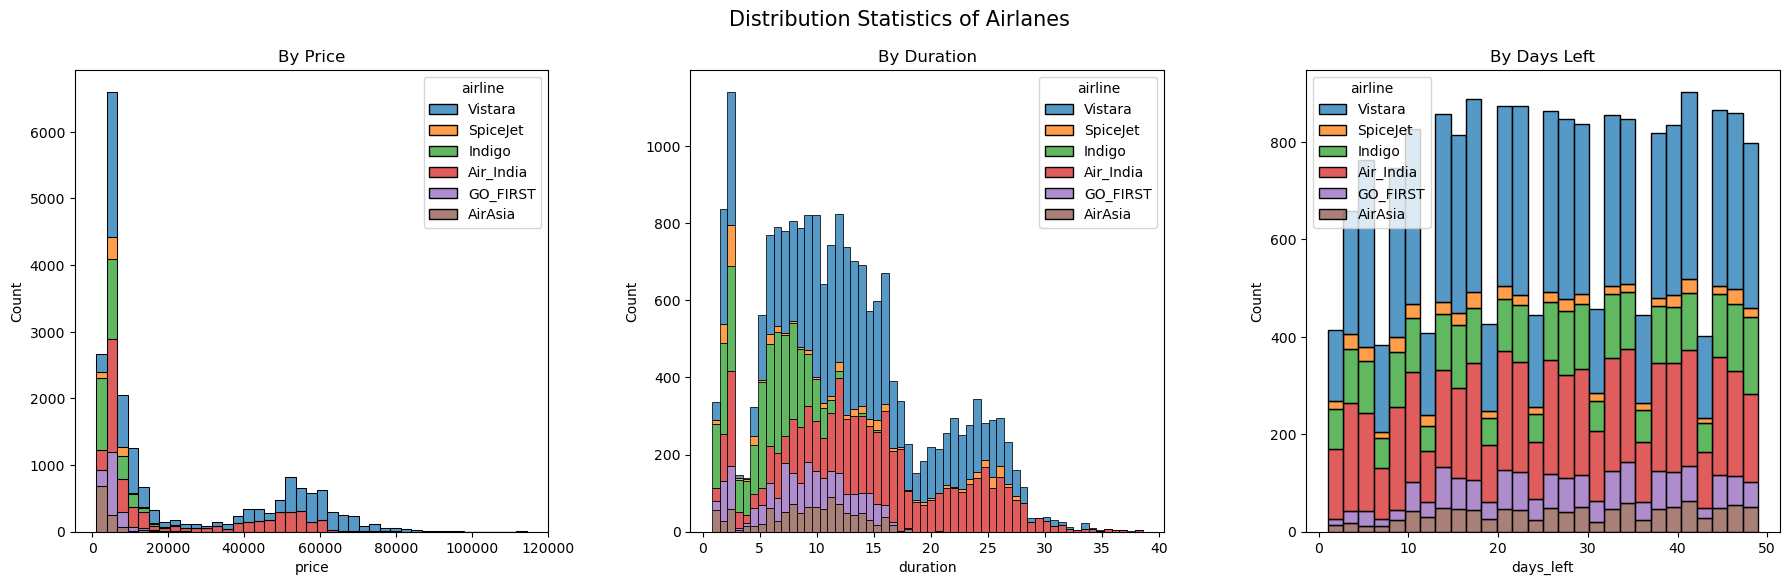

In [147]:
fig,ax=plt.subplots(1,3,figsize=(22,6))
fig.suptitle('Distribution Statistics of Airlanes',fontsize=15)
fig.subplots_adjust(wspace=0.3,hspace=0.3)

sns.histplot(ax=ax[0],data=train,x='price',hue='airline',multiple='stack')
sns.histplot(ax=ax[1],data=train,x='duration',hue='airline',multiple='stack')
sns.histplot(ax=ax[2],data=train,x='days_left',hue='airline',multiple='stack')

ax[0].set_title('By Price',fontsize=12)
ax[1].set_title('By Duration',fontsize=12)
ax[2].set_title('By Days Left',fontsize=12)
plt.show()

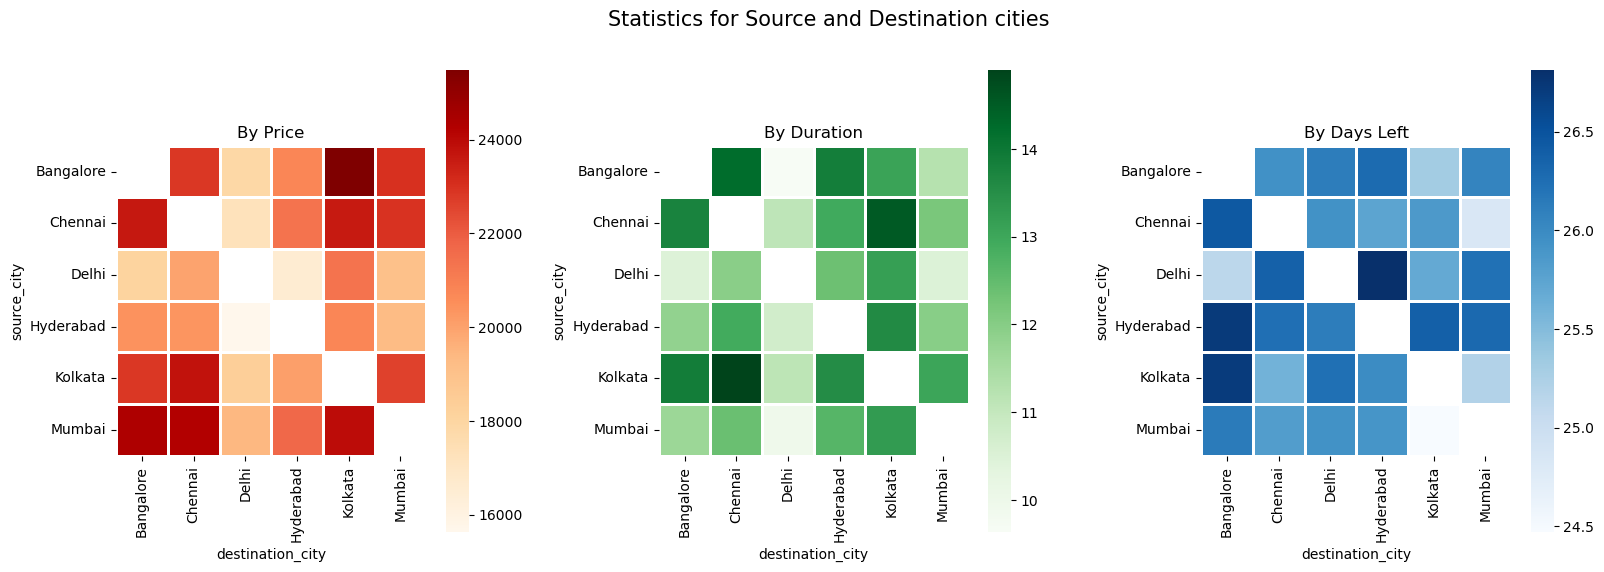

In [148]:
def route(col): return train.groupby(['source_city','destination_city'])[col].mean().unstack(level=1)
fig,ax=plt.subplots(1,3,figsize=(19,6))
fig.suptitle('Statistics for Source and Destination cities',fontsize=15)
fig.subplots_adjust(wspace=0.4)

sns.heatmap(ax=ax[0],data=route('price'),square=True,linewidth=1,cmap='OrRd')
sns.heatmap(ax=ax[1],data=route('duration'),square=True,linewidth=1,cmap='Greens')
sns.heatmap(ax=ax[2],data=route('days_left'),square=True,linewidth=1,cmap='Blues')

ax[0].set_title('By Price',fontsize=12)
ax[1].set_title('By Duration',fontsize=12)
ax[2].set_title('By Days Left',fontsize=12)
plt.show()

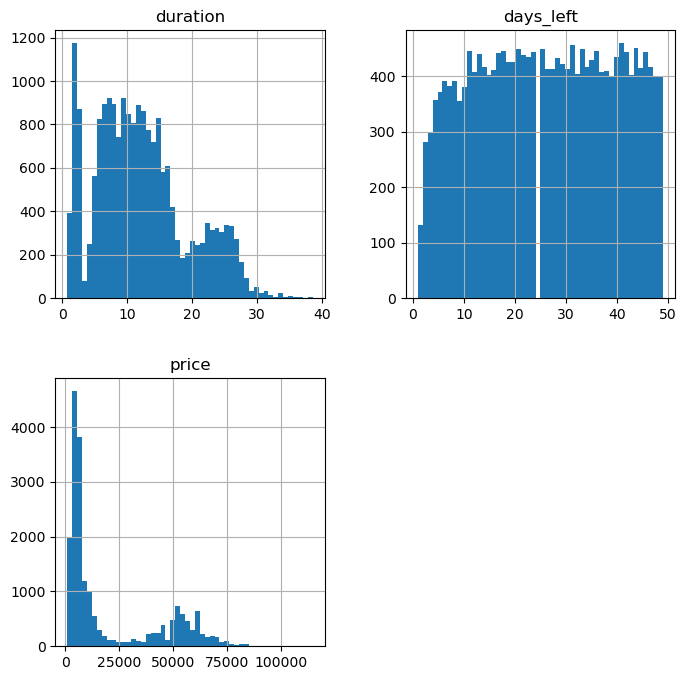

In [149]:
train.hist(bins=50,figsize=(8,8))
plt.show()

#### Qo'shimcha ma'lumotlar orqali biz yaxshi korrelatsiyalar sonini oshirishimiz mumkin.(Ammo price va boshqa biron-bir ustunning korrelatsiyasini modelni ishlatishda foydalana olmaymiz,chunki bizning test setimizda price ustuni yo'q)

In [150]:
train_add=train.copy()
train_add['price_duration_sub']=train_add['price']/train['duration']
train_add['price_days_sub']=train_add['price']/train['days_left']
train_add['duration_days_sub']=train_add['duration']/train['days_left']
train_add.corrwith(train_add.price).abs().sort_values(ascending=False)

price                 1.000000
price_duration_sub    0.658539
price_days_sub        0.458532
duration              0.213158
duration_days_sub     0.140916
days_left             0.102545
dtype: float64

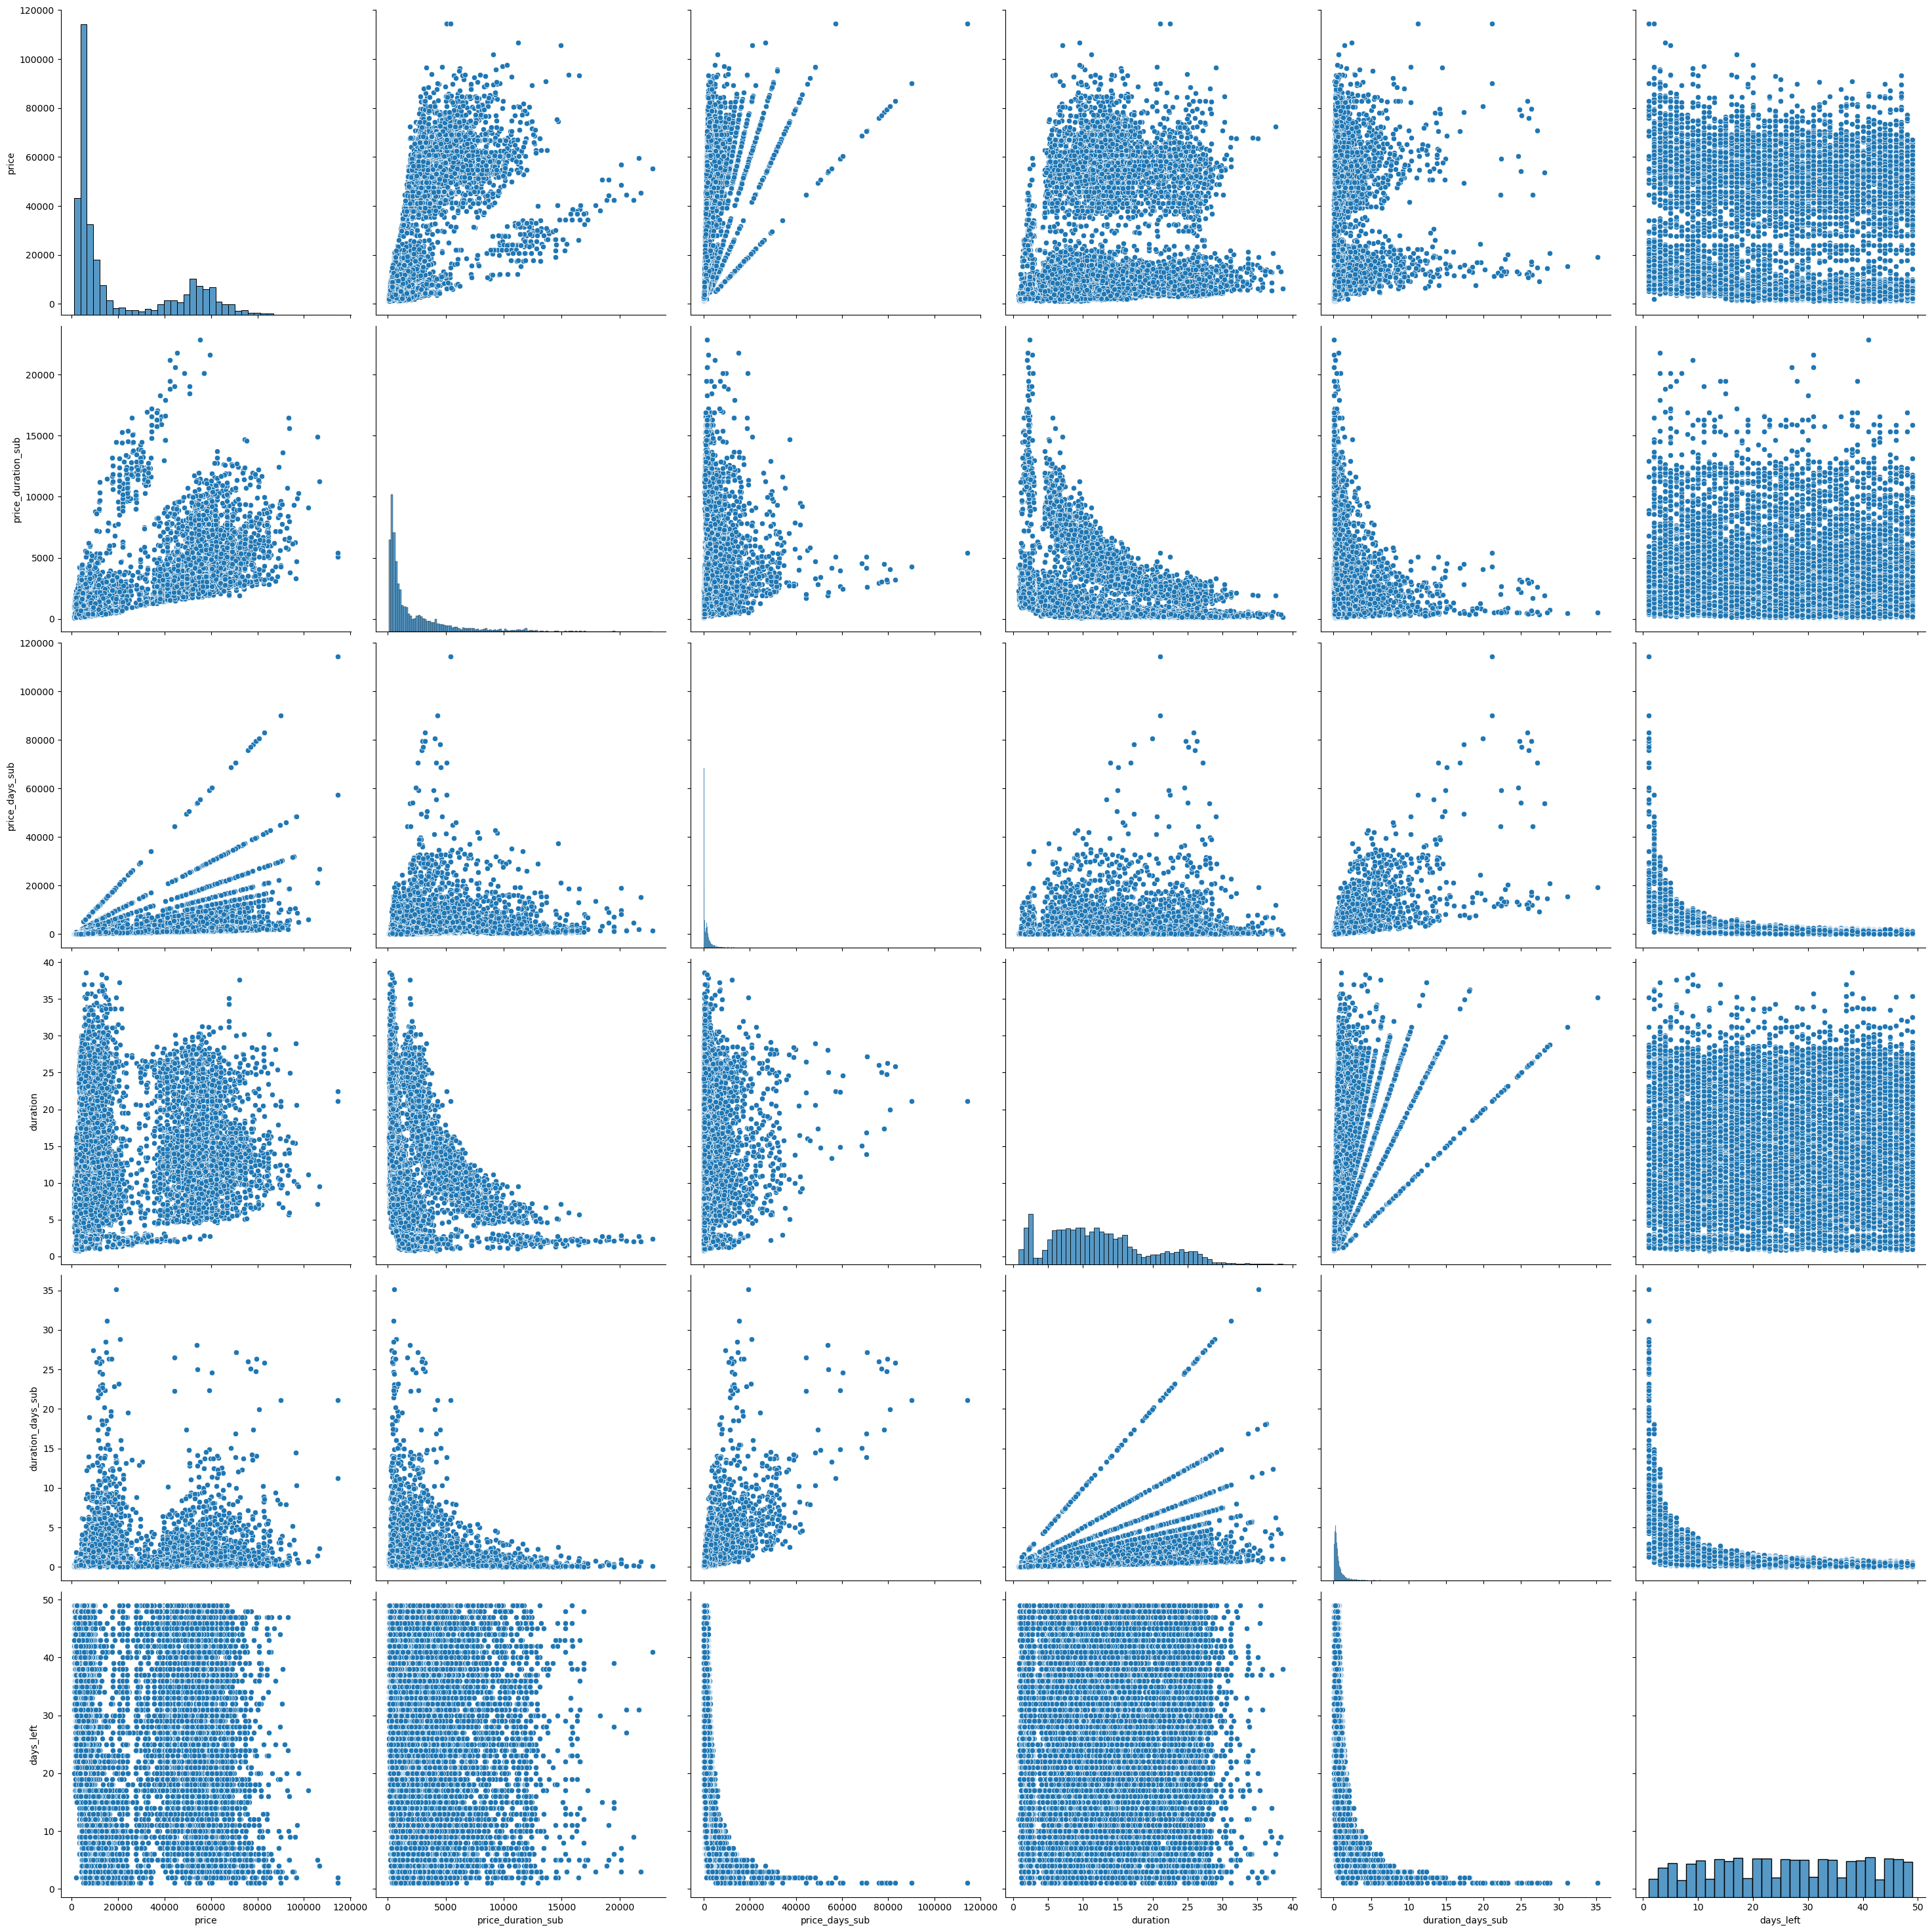

In [151]:
cols=['price','price_duration_sub','price_days_sub','duration','duration_days_sub','days_left']
sns.pairplot(train_add[cols],height=5)
plt.show()

# Ma'lumotlarni tayyorlash

#### Endi navbat ma'lumotlarni model uchun tayyorlaymiz,buning uchun turli xil sklearnda mavjud transformerlar va o'z tajribamizdan foydalanamiz

In [152]:
train.head()

,airline,flight,source_city,departure_time,stops,arrival_time,destination_city,class,duration,days_left,price
id,,,,,,,,,,,
1,Vistara,UK-810,Bangalore,Early_Morning,one,Night,Mumbai,Economy,14.25,21,7212
2,SpiceJet,SG-5094,Hyderabad,Evening,zero,Night,Kolkata,Economy,1.75,7,5292
3,Vistara,UK-846,Bangalore,Morning,one,Evening,Delhi,Business,9.58,5,60553
4,Vistara,UK-706,Kolkata,Morning,one,Evening,Hyderabad,Economy,6.75,28,5760
5,Indigo,6E-5394,Chennai,Early_Morning,zero,Morning,Mumbai,Economy,2.00,4,10712


In [153]:
cols=['airline','source_city','departure_time','stops','arrival_time','destination_city','class']
training=train.drop('flight',axis=1)
testing=test.drop('flight',axis=1)
for col in cols:
    training[col]=LabelEncoder().fit_transform(training[col])
    testing[col]=LabelEncoder().fit_transform(testing[col])
#training[['duration','days_left']]=training[['duration','days_left']]/training[['duration','days_left']].max()
#testing[['duration','days_left']]=testing[['duration','days_left']]/testing[['duration','days_left']].max()
X_prepared=training.drop('price',axis=1).values
train_y=training['price'].values
test_prepared=testing.copy().values    

# Machine Learning

#### ML ning qaysi modeli yaxshi natija berayotganini aniqlash uchun train datani o'zida fit va predict qilishga qaror qildim.

In [154]:
LR=LinearRegression()
RF=RandomForestRegressor(random_state=23)
GBR=GradientBoostingRegressor()
Tree=DecisionTreeRegressor()
Svr=SVR()
las=Lasso()
Xgb=XGBRegressor()
def model_evaluation(model_name):
    model=model_name.fit(X_prepared,train_y)
    predict=model.predict(X_prepared)
    MSE=mean_absolute_error(train_y,predict)
    RMSE=np.sqrt(mean_squared_error(train_y,predict))
    R2=r2_score(train_y,predict)*100
    return [MSE,RMSE,R2]

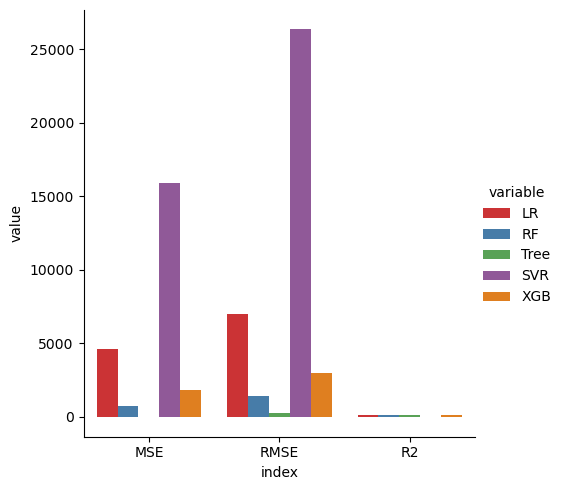

In [155]:
data={'LR':model_evaluation(LR),
      'Lasso':model_evaluation(las),
      'RF':model_evaluation(RF),
      'GBR':model_evaluation(GBR),
      'Tree':model_evaluation(Tree),
      'SVR':model_evaluation(Svr),
      'XGB':model_evaluation(Xgb)}
model_stats=pd.DataFrame(data)
model_stats.rename(index={0:'MSE',1:'RMSE',2:'R2'},inplace=True)
model_stats.reset_index(inplace=True)

cols=['LR','RF','Tree','SVR','XGB']
melted=pd.melt(model_stats,id_vars='index',value_vars=cols)
sns.catplot(data=melted,kind='bar',x='index',y='value',hue='variable',palette='Set1')
plt.show()

In [156]:
model_stats

,index,LR,Lasso,RF,GBR,Tree,SVR,XGB
0,MSE,4633.725973,4633.464144,734.747122,2914.345906,7.550050,15873.736043,1791.792403
1,RMSE,6988.310732,6988.311342,1414.483255,4868.340781,252.564396,26354.622117,2997.204665
2,R2,90.584750,90.584749,99.614270,95.430703,99.987702,-33.906299,98.268110


#### Grafikdan DecisionTree modelida eng yaxshi natija kuzatildi(eng pastdagi ustun eng yaxshi natija).Ammo bu Overfitting muammosini olib kelishi mumkin.Shu sababli RandomForest modelini yaxshi deb olamiz

In [157]:
from sklearn.model_selection import cross_val_score
RF=RandomForestRegressor(n_estimators=10,random_state=23)
scoring=cross_val_score(estimator=RF,X=X_prepared,y=train_y,scoring='neg_mean_squared_error',cv=5)
print(f"Cross Validation:{np.sqrt(np.abs(scoring))}")

Cross Validation:[3979.1757926  4102.10642637 4012.02090471 4142.16668622 4133.76686905]


#### ML ning modellari o'zining hyperparameteriga ega.Biz bu hyperparameterlarni o'zgartirish orqali modelning ishlash tezligi va aniqligiga ta'sir qilishimiz mumkin

#### RandomForest algoritmini tuning qilish uchun n_estimators hyperparametridan foydalanib ko'ramiz

In [158]:
RF=RandomForestRegressor(random_state=23)
RF.fit(X_prepared,train_y)
params={'n_estimators':np.arange(1,11)}
grid=GridSearchCV(RF,params,cv=5)
grid.fit(X_prepared,train_y)
grid.cv_results_

{'mean_fit_time': array([0.02771983, 0.05490317, 0.08123546, 0.11224756, 0.14430704,
        0.16954608, 0.20550947, 0.21640186, 0.24133425, 0.4641664 ]),
 'std_fit_time': array([0.0007747 , 0.00110029, 0.00120191, 0.00739096, 0.0089839 ,
        0.00634758, 0.01281653, 0.00202865, 0.00200463, 0.09981793]),
 'mean_score_time': array([0.00140586, 0.00176511, 0.00244927, 0.00358801, 0.0041666 ,
        0.00518408, 0.00619431, 0.00658188, 0.00718889, 0.01415477]),
 'std_score_time': array([0.00049576, 0.00038726, 0.00046229, 0.00048585, 0.00037428,
        0.00039809, 0.00039396, 0.00049279, 0.0004074 , 0.00311228]),
 'param_n_estimators': masked_array(data=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
              mask=[False, False, False, False, False, False, False, False,
                    False, False],
        fill_value='?',
             dtype=object),
 'params': [{'n_estimators': 1},
  {'n_estimators': 2},
  {'n_estimators': 3},
  {'n_estimators': 4},
  {'n_estimators': 5},
  {'n_estimators

#### Bu yerda biz eng yaxshi hyperparametrni topamiz

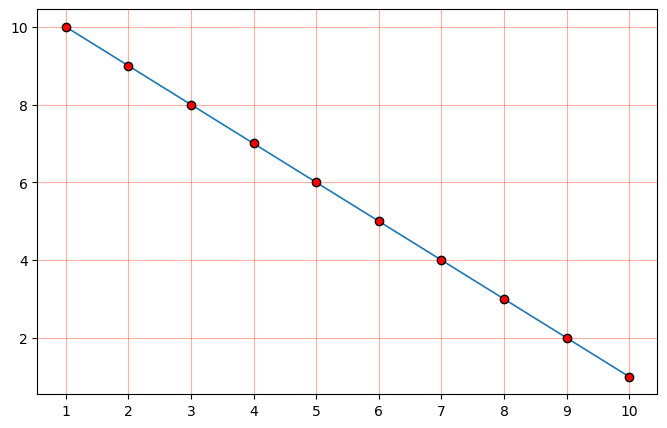

In [159]:
plt.figure(figsize=(8,5))
plt.plot(np.arange(1,11),
         grid.cv_results_['rank_test_score'],
         linewidth=1.2,
         marker='o',
         markerfacecolor='r',
         markeredgecolor='k')
plt.grid(color='tomato',alpha=0.5)
plt.xticks(np.arange(1,11))
plt.show()

#### Eng yaxshi n_estimators 10  ekan.(Umuman olganda n_estimators qancha oshsa shuncha yaxshi ishlamoqda).Random Forest algoritmida standard holatda: n_estimators=100

In [168]:
RF_h=RandomForestRegressor(n_estimators=10,random_state=23)
RF_h.fit(X_prepared,train_y)
prediction=RF_h.predict(test_prepared)
prediction

array([54040.8, 64736. , 23385. , ..., 50000.7, 49315.5, 58615. ])

In [161]:
x=RF_h.predict(X_prepared)
print(f"RMSE: {np.sqrt(mean_squared_error(x,train_y))}")
print(f"MSE: {mean_absolute_error(x,train_y)}")
print(f"R2: {r2_score(x,train_y)}")

RMSE: 1692.8239271170542
MSE: 811.6412140119047
R2: 0.99439428388194


#### Biz n_estimatorsiz model quramiz

#### KFold cross-validation orqali modelimizni bir neacha marta training qilib ko'rishimiz mumkin

In [162]:
X = training.drop('price',axis=1).copy()
y = training['price']

kfold = KFold(n_splits=5, shuffle=True,random_state=23)
rmse_scores = []
mae_scores=[]
r2_scores=[]
predictions=[]

for train_idx, test_idx in kfold.split(X):
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

    rf_model = RandomForestRegressor(random_state=23)
    rf_model.fit(X_train, y_train)
       
    y_pred = rf_model.predict(testing)
    y_pred_test = rf_model.predict(X_test)
    predictions.append(y_pred)

    mae = mean_absolute_error(y_test, y_pred_test)
    mae_scores.append(mae)
    rmse = np.sqrt(np.abs(mean_squared_error(y_test, y_pred_test)))
    rmse_scores.append(rmse)
    r2 = r2_score(y_test, y_pred_test)
    r2_scores.append(r2)
  

### Xulosa: Eng yaxshi model - Kfold cross validation orqali Random Forestda bashorat qilingan model

In [163]:
final_result=np.median(np.column_stack(predictions),axis=1)
print(f"""RMSE: {np.mean(rmse_scores)}
MAE: {np.mean(mae_scores)}
R2: {np.mean(r2_scores)}""")

RMSE: 3898.1313555831985
MAE: 2074.441080998214
R2: 0.9706877870456863


In [164]:
data=pd.DataFrame(final_result,columns=['price'])
data.index=np.arange(1,len(data)+1)
data.index.name='id'
data.reset_index(inplace=True)
data.to_csv('my_submission.csv',index=False)

In [167]:
test_prepared

array([[ 1.  ,  4.  ,  2.  , ...,  0.  , 28.25,  2.  ],
       [ 5.  ,  2.  ,  1.  , ...,  0.  , 13.83, 34.  ],
       [ 1.  ,  5.  ,  1.  , ...,  0.  ,  2.  , 30.  ],
       ...,
       [ 1.  ,  4.  ,  4.  , ...,  0.  , 11.17, 37.  ],
       [ 1.  ,  5.  ,  1.  , ...,  0.  , 13.33, 38.  ],
       [ 5.  ,  4.  ,  5.  , ...,  0.  , 16.08, 49.  ]])